In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
import joblib

# Cargar los datos
df = pd.read_csv("../data/bajapvasco_filtro.csv")
df["CPV"] = df["CPV"].astype("str")

# Dividir entre características y variable objetivo
df_columnas_numericas = df._get_numeric_data()
df_columnas_categoricas = df.drop(columns=df_columnas_numericas.columns)
df_columnas_categoricas = pd.get_dummies(df_columnas_categoricas, drop_first=True)
df = pd.concat([df_columnas_numericas, df_columnas_categoricas], axis=1)

X = df.drop(["Baja temeraria"], axis=1)
y = df["Baja temeraria"]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Crear el modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'xgbclassifier__n_estimators': [20, 50, 100, 200, 300,500],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.5],
    'xgbclassifier__max_depth': [1, 3, 4, 5, 8],
    'xgbclassifier__scale_pos_weight': [1, 5, 10],
    'xgbclassifier__eval_metric': ['aucpr'], 
}

scoring = ["accuracy","roc_auc"] 

# Crear el pipeline
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('xgbclassifier', model)])

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,refit = "roc_auc", cv=5)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)

# Calcular y mostrar métricas para el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
classification_rep_train = classification_report(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)

print("\nMétricas para el conjunto de entrenamiento:")
print("\nAccuracy:", accuracy_train)
print("\nConfusion Matrix:\n", conf_matrix_train)
print("\nClassification Report:\n", classification_rep_train)
print("\nROC AUC:", roc_auc_train)

# Realizar predicciones en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular y mostrar métricas para el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
classification_rep_test = classification_report(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print("\nMétricas para el conjunto de prueba:")
print("\nAccuracy:", accuracy_test)
print("\nConfusion Matrix:\n", conf_matrix_test)
print("\nClassification Report:\n", classification_rep_test)
print("\nROC AUC:", roc_auc_test)

# Guardar el modelo en un archivo pkl
#joblib.dump(best_model, 'model_XGBoost.pkl')


Mejores hiperparámetros: {'xgbclassifier__eval_metric': 'aucpr', 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__scale_pos_weight': 1}

Métricas para el conjunto de entrenamiento:

Accuracy: 0.8077383326685281

Confusion Matrix:
 [[1471  141]
 [ 341  554]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1612
           1       0.80      0.62      0.70       895

    accuracy                           0.81      2507
   macro avg       0.80      0.77      0.78      2507
weighted avg       0.81      0.81      0.80      2507


ROC AUC: 0.7657627153887742

Métricas para el conjunto de prueba:

Accuracy: 0.772020725388601

Confusion Matrix:
 [[787 101]
 [207 256]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       888
           1       0.72      0.55      0.62   

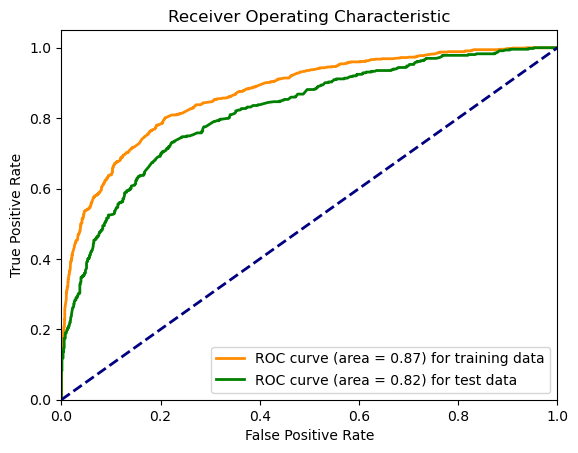

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular las probabilidades de las clases
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Calcular el área bajo la curva ROC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Crear el gráfico
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for training data' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (area = %0.2f) for test data' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
